In [79]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum

class ActivationFuction(Enum):
    SIGMOID = 1
    RELU = 2,
    ELU = 3 # a = 1

class Problem(Enum):
    Classification = 1,
    Regression = 2

class NeuralNetwork:
    def __init__(self, 
                 input_size = 784, 
                 hidden_size = 128, 
                 output_size = 10, 
                 hidden_layers_count = 1, 
                 inner_activation_function = ActivationFuction.SIGMOID,
                 problem = Problem.Classification,
                 learning_rate = 0.01, 
                 num_epochs = 10, 
                 seed = 0, 
                 use_bias = True,
                 visualize = False) -> None:
        self.seed = seed
        np.random.seed(self.seed)
        self.use_bias = use_bias
        self.hidden_layers_count = hidden_layers_count
        self.input_size = input_size 
        self.hidden_size = hidden_size
        self.visualize = visualize
        
        if problem == Problem.Regression:
            self.output_size = 1
            self.input_size = 1
        else:
            self.output_size = output_size
            
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.inner_activation_function = inner_activation_function
        self.problem = problem
 
        self.layers_sizes = [self.input_size] + [self.hidden_size] * self.hidden_layers_count + [self.output_size]
        self.layers_count = len(self.layers_sizes)
        self.weights_count = self.layers_count - 1

        self.weights = [None] * self.weights_count 
        self.bias = [None] * self.weights_count 
        self.create_weights_array()

    def create_weights_array(self):
        for i in range(self.weights_count):
            if self.inner_activation_function == ActivationFuction.SIGMOID:
                self.weights[i] = np.random.uniform(-np.sqrt(6 / (self.layers_sizes[i] + self.layers_sizes[i + 1])), np.sqrt(6 / (self.layers_sizes[i] + self.layers_sizes[i + 1])), size=(self.layers_sizes[i], self.layers_sizes[i + 1]))
            else:
                self.weights[i] = np.random.normal(0, np.sqrt(2 / (self.layers_sizes[i] + self.layers_sizes[i + 1])), size=(self.layers_sizes[i], self.layers_sizes[i + 1]))
    
            if self.use_bias:
                self.bias[i] = np.zeros(self.layers_sizes[i + 1])
                
    def train_and_check_acc(self, train_inputs, train_results, test_inputs, test_results):
    
        for epoch in range(self.num_epochs):
            for i in range(len(train_inputs)):
                self.train(train_inputs[i], train_results[i])
                
            if(self.visualize):
                    fig = plt.figure(figsize = (20, 12)) # width x height
                    for i in range(self.weights_count):
                        ax1 = fig.add_subplot(3, 5, i+1) # row, column, position
                        sns.heatmap(self.weights[i], cmap="coolwarm", ax=ax1) # jaka paleta? moze Spectral albo magma?
                        plt.title(f'Weight Heatmap - Layers {i}-{i+1}')
                        mean = np.mean(self.weights[i])
                        std = np.std(self.weights[i])
                        print(f'Layers {i}-{i+1}: Mean={mean}, Std={std}')
                    plt.show()
                        
                
            correct = 0
            nn_results = []
            for i in range(len(test_inputs)):
                values = self.predict(test_inputs[i])
                nn_results.append(values[-1])
                
                if (self.problem == Problem.Classification):  
                   if np.argmax(values[-1]) == np.argmax(test_results[i]):
                        correct += 1
                        
            error = self.accuracy(nn_results, test_results)  
            if (self.problem == Problem.Classification):
                test_accuracy = correct / len(test_inputs)
                print(f"Epoch {epoch + 1}/{self.num_epochs}, Test Accuracy: {test_accuracy * 100:.2f}% Loss: {error}, Correct: {correct}, All: {len(test_inputs)} ")
            else:
                print(f"Epoch {epoch + 1}/{self.num_epochs}, Test Accuracy: {error}")
            
    def accuracy(self, results, expected_result):
        if self.problem == Problem.Classification:
            return -np.sum(expected_result * np.log(results[-1]))
        else:
            return np.average(np.power(expected_result - results, 2))

        
    def train(self, input, expected_result): # Backpropagation
        values = self.predict(input)
    
        delta = [None] * self.weights_count
        delta[-1] = values[-1] - expected_result
        
        for weightId in range(self.weights_count - 2, -1, -1):
            delta[weightId] = np.dot(delta[weightId + 1], self.weights[weightId + 1].T) * self.neuron_activation_derivative(values[weightId + 1])
            
        for weightId in range(self.weights_count):
            self.weights[weightId] -= np.outer(values[weightId], delta[weightId]) * self.learning_rate 
            if self.use_bias:
                self.bias[weightId] = self.bias[weightId] - delta[weightId] * self.learning_rate
        
    
    def neuron_activation(self, v):
        if self.inner_activation_function == ActivationFuction.SIGMOID:
            return 1 / (1 + np.exp(-v))
        elif self.inner_activation_function == ActivationFuction.RELU:
            return np.maximum(0, v)
        elif self.inner_activation_function == ActivationFuction.ELU:
            return (v > 0) * 1 + (v <= 0) * np.exp(v) 
        
    def neuron_activation_derivative(self, v):
        if self.inner_activation_function == ActivationFuction.SIGMOID:
            return v * (1 - v)
        elif self.inner_activation_function == ActivationFuction.RELU:
            return (v > 0) * 1
        elif self.inner_activation_function == ActivationFuction.ELU:
            return (v > 0) * v + (v <= 0) * (np.exp(v) - 1) 
    
    def output_activation(self, x):
        if self.problem == Problem.Classification:
            exp_x = np.exp(x - np.max(x))
            return exp_x / exp_x.sum()
        else: 
            return x
    
    def predict(self, input): #forward propagation
        values = [None] * self.layers_count
        
        values[0] = input
        
        for weightId in range(self.weights_count):
           v = np.dot(values[weightId], self.weights[weightId]) + self.bias[weightId] if self.use_bias else 0
           if weightId != self.weights_count - 1:
               v = self.neuron_activation(v)
           else:    
               v = self.output_activation(v)
               
           values[weightId + 1] = v  
        
        return values

In [69]:
import numpy as np
from mnist.loader import MNIST

# Load the MNIST dataset
mndata = MNIST("C:\\Users\\jkobo\\source\\repos\\sn1\\mnist-digit-recognition\\data")  # Replace with the path to your MNIST data
mndata.gz = True

# Load the training and testing data
train_images, train_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()

# Convert to NumPy arrays for easier manipulation
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Normalize pixel values to be between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

num_classes = 10
train_labels = np.eye(num_classes)[train_labels]
test_labels = np.eye(num_classes)[test_labels]

nn = NeuralNetwork(num_epochs=25, hidden_layers_count=4, hidden_size=78,  inner_activation_function = ActivationFuction.RELU)

nn.train_and_check_acc(train_images, train_labels, test_images, test_labels)

Epoch 1/25, Test Accuracy: 94.50% Loss: 148987.8099009454, Correct: 9450, All: 10000 
Epoch 2/25, Test Accuracy: 95.80% Loss: 167702.38812139485, Correct: 9580, All: 10000 
Epoch 3/25, Test Accuracy: 96.11% Loss: 186759.3588488006, Correct: 9611, All: 10000 
Epoch 4/25, Test Accuracy: 96.72% Loss: 166758.24541385032, Correct: 9672, All: 10000 
Epoch 5/25, Test Accuracy: 95.99% Loss: 217420.3514042992, Correct: 9599, All: 10000 
Epoch 6/25, Test Accuracy: 96.82% Loss: 186973.5694611423, Correct: 9682, All: 10000 
Epoch 7/25, Test Accuracy: 97.11% Loss: 172315.7261019609, Correct: 9711, All: 10000 
Epoch 8/25, Test Accuracy: 97.09% Loss: 244473.95129345375, Correct: 9709, All: 10000 
Epoch 9/25, Test Accuracy: 96.61% Loss: 226466.33684788237, Correct: 9661, All: 10000 
Epoch 10/25, Test Accuracy: 96.95% Loss: 248806.8844620203, Correct: 9695, All: 10000 
Epoch 11/25, Test Accuracy: 97.12% Loss: 251131.37381312042, Correct: 9712, All: 10000 
Epoch 12/25, Test Accuracy: 97.30% Loss: 287672

In [ ]:
import numpy as np
import pandas as pd

test = pd.read_csv("classification/data.simple.test.100.csv", sep=",")
train = pd.read_csv("classification/data.simple.train.100.csv", sep=",")

train_vectors = np.array(train[["x", "y"]])
train_results = np.array(train["cls"] - 1)
test_vectors = np.array(test[["x", "y"]])
test_results = np.array(test["cls"] - 1)

num_classes = 2
train_results = np.eye(num_classes)[train_results]
test_results = np.eye(num_classes)[test_results]

nn = NeuralNetwork(input_size = 2, output_size = num_classes, hidden_size = 2, hidden_layers_count = 4, num_epochs = 3, inner_activation_function = ActivationFuction.RELU, visualize=True)
nn.train_and_check_acc(train_vectors, train_results, test_vectors, test_results)

In [ ]:
import numpy as np
import pandas as pd

test = pd.read_csv("classification/data.simple.test.10000.csv", sep=",")
train = pd.read_csv("classification/data.simple.train.10000.csv", sep=",")

train_vectors = np.array(train[["x", "y"]])
train_results = np.array(train["cls"] - 1)
test_vectors = np.array(test[["x", "y"]])
test_results = np.array(test["cls"] - 1)

num_classes = 2
train_results = np.eye(num_classes)[train_results]
test_results = np.eye(num_classes)[test_results]

nn = NeuralNetwork(input_size = 2, output_size = num_classes, hidden_size = 2, hidden_layers_count = 4, num_epochs = 5, inner_activation_function = ActivationFuction.SIGMOID)
nn.train_and_check_acc(train_vectors, train_results, test_vectors, test_results)

Layers 0-1: Mean=0.23191307039147305, Std=0.3472539669054589
Layers 1-2: Mean=-0.05698779581235775, Std=0.46816525613893956


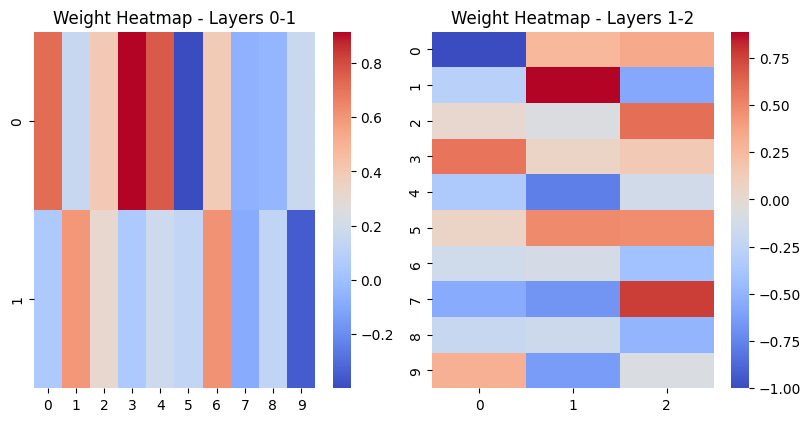

Epoch 1/25, Test Accuracy: 37.33% Loss: 330.7108658126609, Correct: 112, All: 300 
Layers 0-1: Mean=0.23140457373196205, Std=0.3474306354822573
Layers 1-2: Mean=-0.056987795812357765, Std=0.46808934428491566


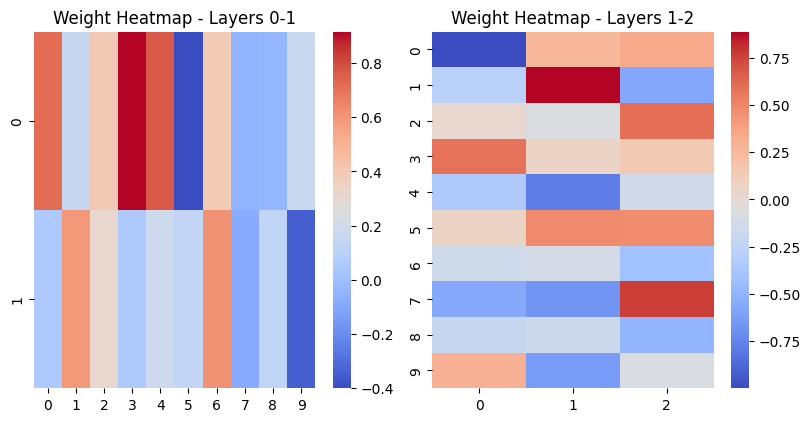

Epoch 2/25, Test Accuracy: 39.67% Loss: 330.7744120922635, Correct: 119, All: 300 
Layers 0-1: Mean=0.23089749632156958, Std=0.34762004721847073
Layers 1-2: Mean=-0.056987795812357765, Std=0.46802383857738517


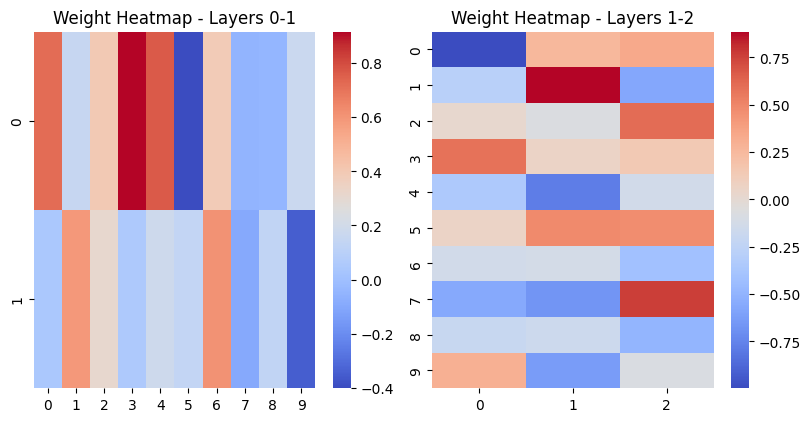

Epoch 3/25, Test Accuracy: 43.67% Loss: 330.8428283297149, Correct: 131, All: 300 
Layers 0-1: Mean=0.23039386451234906, Std=0.34782088757027235
Layers 1-2: Mean=-0.0569877958123578, Std=0.4679687390484226


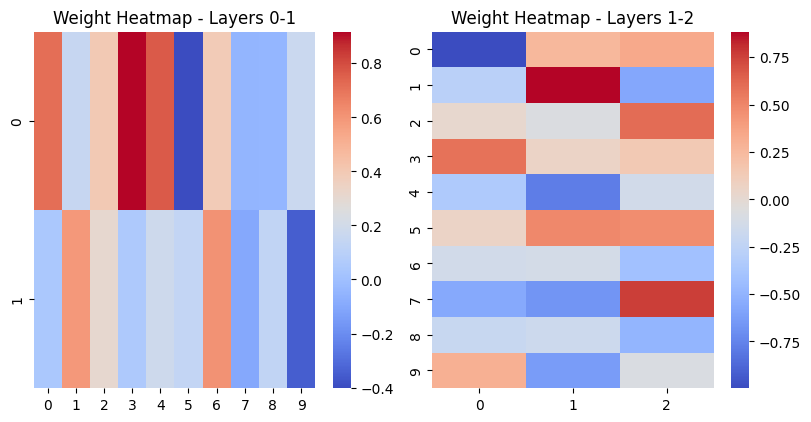

Epoch 4/25, Test Accuracy: 46.33% Loss: 330.9170475990889, Correct: 139, All: 300 
Layers 0-1: Mean=0.22989345319857973, Std=0.3480335675844429
Layers 1-2: Mean=-0.056987795812357814, Std=0.46792382659376625


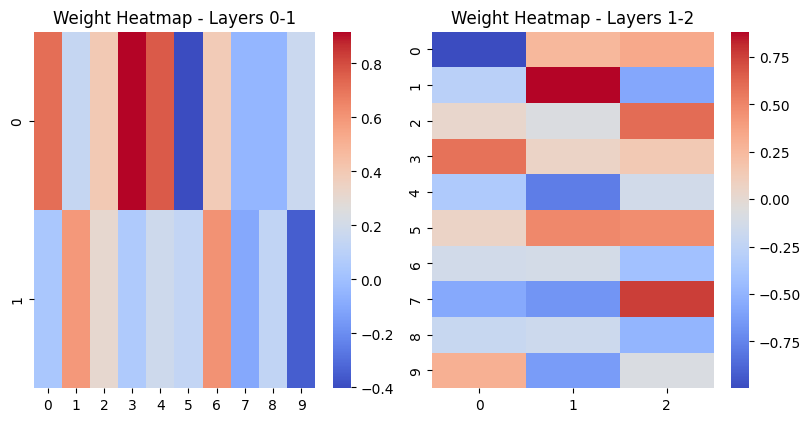

Epoch 5/25, Test Accuracy: 49.33% Loss: 330.9942707809629, Correct: 148, All: 300 
Layers 0-1: Mean=0.22939533725029185, Std=0.3482584376391262
Layers 1-2: Mean=-0.05698779581235779, Std=0.467888959645756


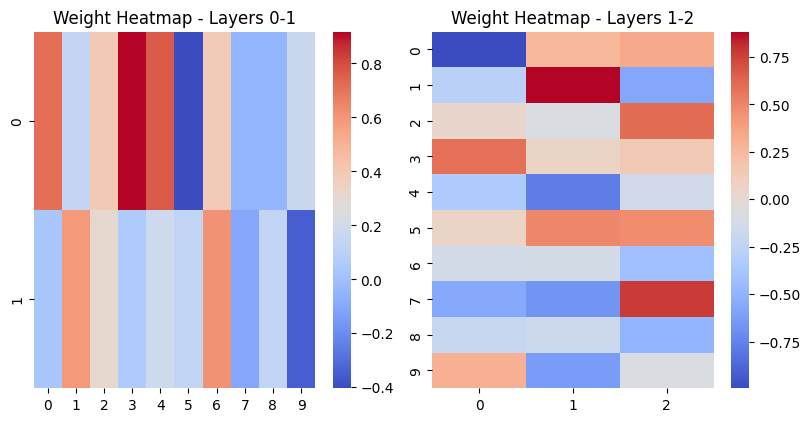

Epoch 6/25, Test Accuracy: 51.00% Loss: 331.0727659165975, Correct: 153, All: 300 
Layers 0-1: Mean=0.2289013182135183, Std=0.34849447119589866
Layers 1-2: Mean=-0.05698779581235774, Std=0.4678640512789155


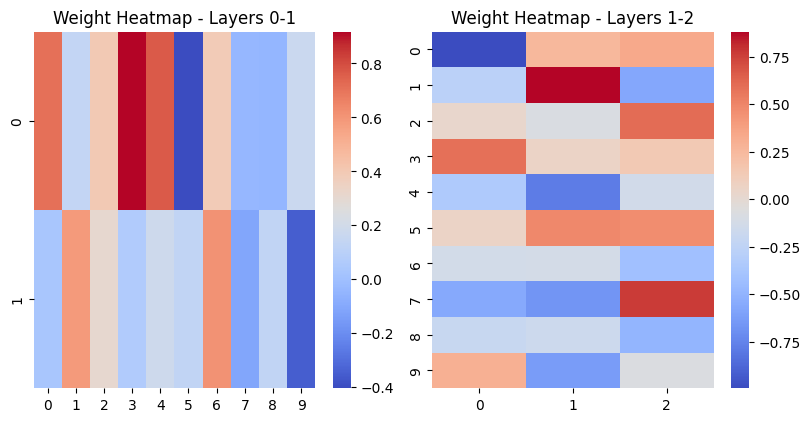

Epoch 7/25, Test Accuracy: 53.00% Loss: 331.15305825055736, Correct: 159, All: 300 
Layers 0-1: Mean=0.22841131572495862, Std=0.3487406406349931
Layers 1-2: Mean=-0.056987795812357765, Std=0.46784900698350995


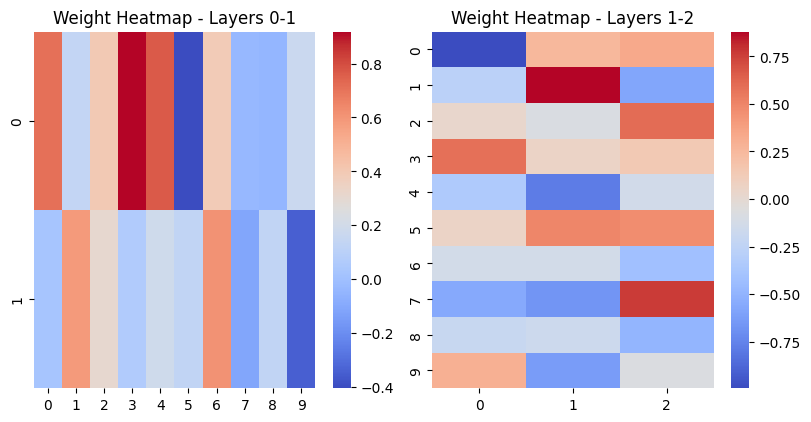

Epoch 8/25, Test Accuracy: 54.00% Loss: 331.2362819726005, Correct: 162, All: 300 
Layers 0-1: Mean=0.2279228202842774, Std=0.34899867027431875
Layers 1-2: Mean=-0.056987795812357675, Std=0.4678438542489204


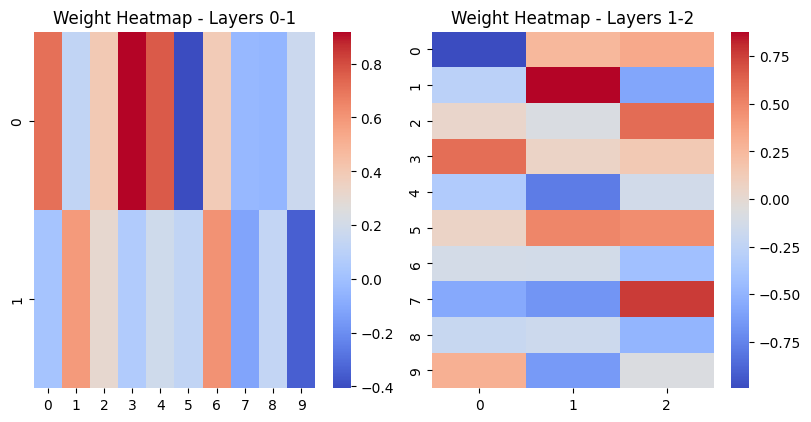

Epoch 9/25, Test Accuracy: 56.00% Loss: 331.3220678835389, Correct: 168, All: 300 
Layers 0-1: Mean=0.22743669193757468, Std=0.34926790816495457
Layers 1-2: Mean=-0.05698779581235771, Std=0.46784851130053345


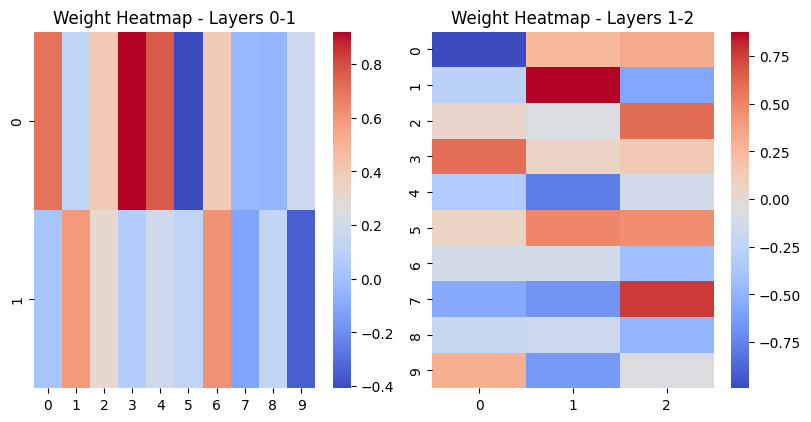

Epoch 10/25, Test Accuracy: 57.67% Loss: 331.41103289759025, Correct: 173, All: 300 
Layers 0-1: Mean=0.22696073395472136, Std=0.3495446985821749
Layers 1-2: Mean=-0.056987795812357696, Std=0.4678628031440142


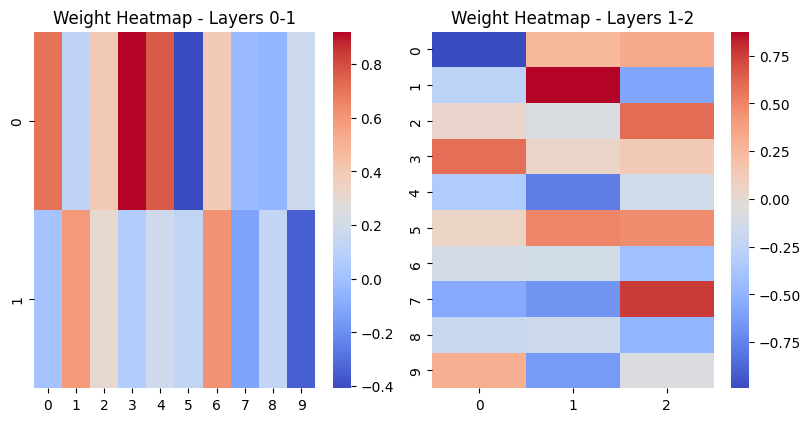

Epoch 11/25, Test Accuracy: 59.33% Loss: 331.50257601782226, Correct: 178, All: 300 
Layers 0-1: Mean=0.22649128647235148, Std=0.3498299512455049
Layers 1-2: Mean=-0.05698779581235769, Std=0.4678865229116653


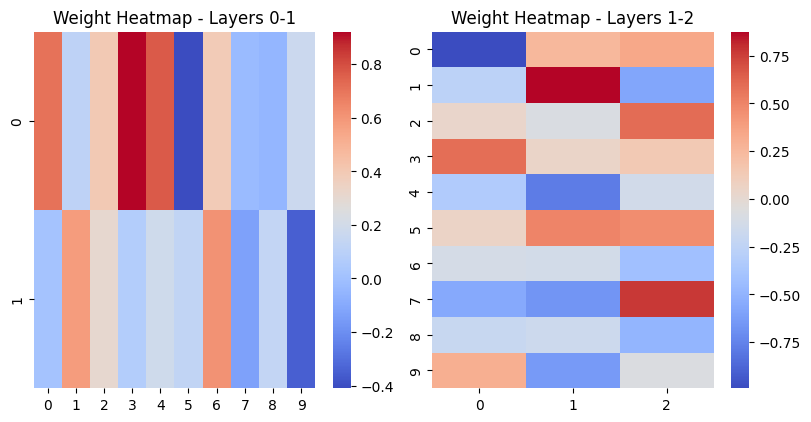

Epoch 12/25, Test Accuracy: 59.67% Loss: 331.59683521864764, Correct: 179, All: 300 
Layers 0-1: Mean=0.2260218143623029, Std=0.350127744969539
Layers 1-2: Mean=-0.056987795812357696, Std=0.4679196642435882


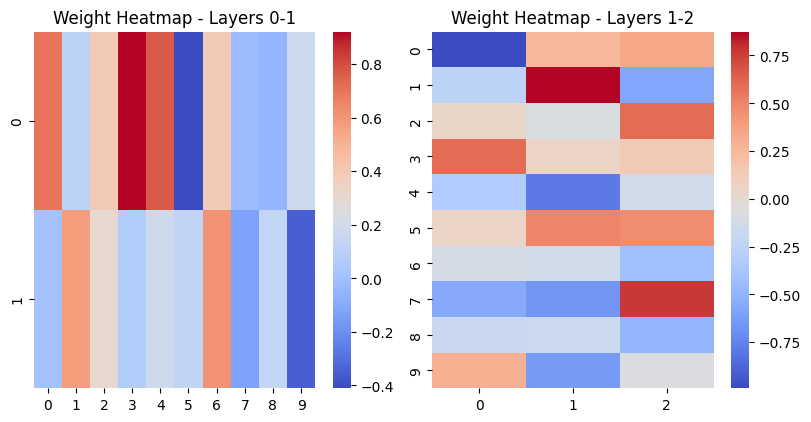

Epoch 13/25, Test Accuracy: 60.00% Loss: 331.6938694720802, Correct: 180, All: 300 
Layers 0-1: Mean=0.22555540620185882, Std=0.35043553635875496
Layers 1-2: Mean=-0.056987795812357675, Std=0.4679621899404775


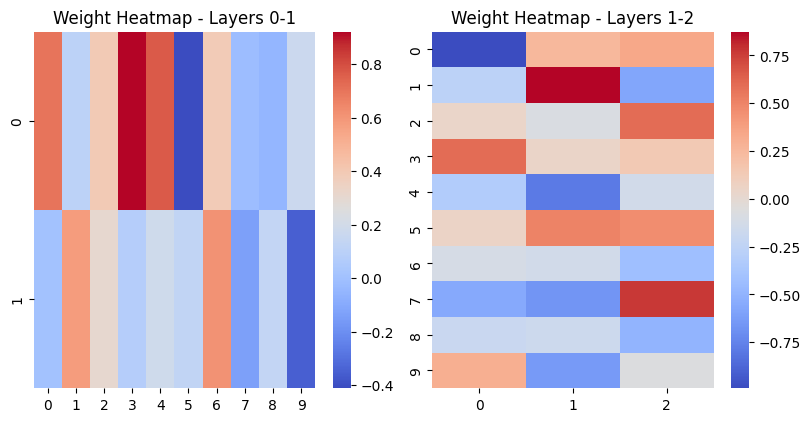

Epoch 14/25, Test Accuracy: 61.00% Loss: 331.7952973996287, Correct: 183, All: 300 
Layers 0-1: Mean=0.2250963599614017, Std=0.35075308567871405
Layers 1-2: Mean=-0.05698779581235765, Std=0.46801406306739646


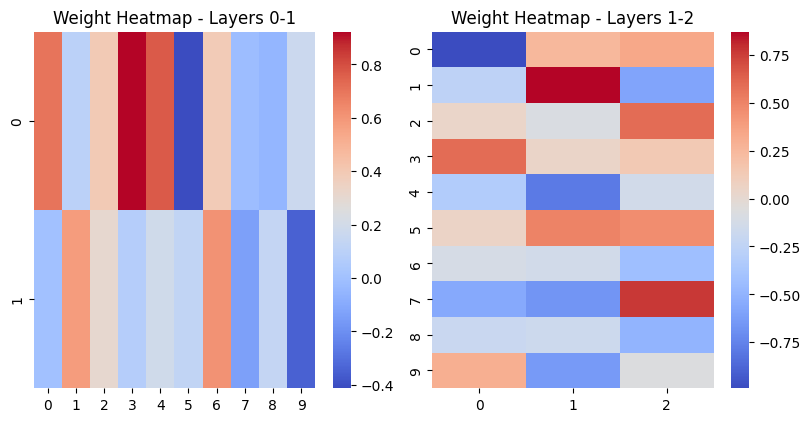

Epoch 15/25, Test Accuracy: 61.33% Loss: 331.8996509404624, Correct: 184, All: 300 
Layers 0-1: Mean=0.22463909072202481, Std=0.35108133100376165
Layers 1-2: Mean=-0.05698779581235756, Std=0.46807513935310724


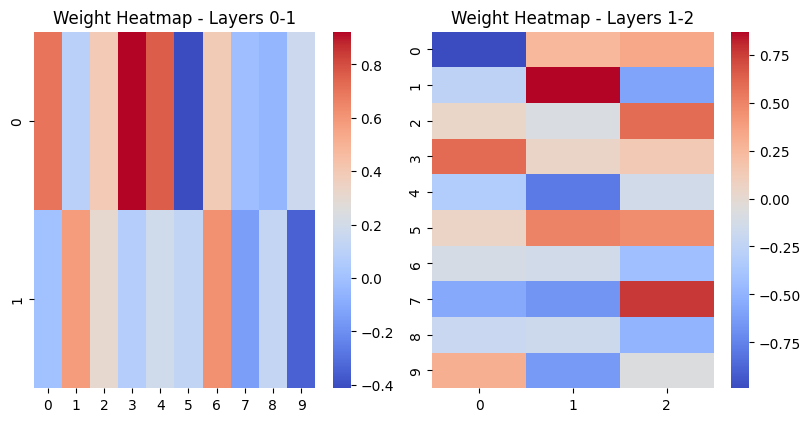

Epoch 16/25, Test Accuracy: 62.00% Loss: 332.0076293612011, Correct: 186, All: 300 
Layers 0-1: Mean=0.22418745769071, Std=0.3514191725440315
Layers 1-2: Mean=-0.05698779581235756, Std=0.46814527536422706


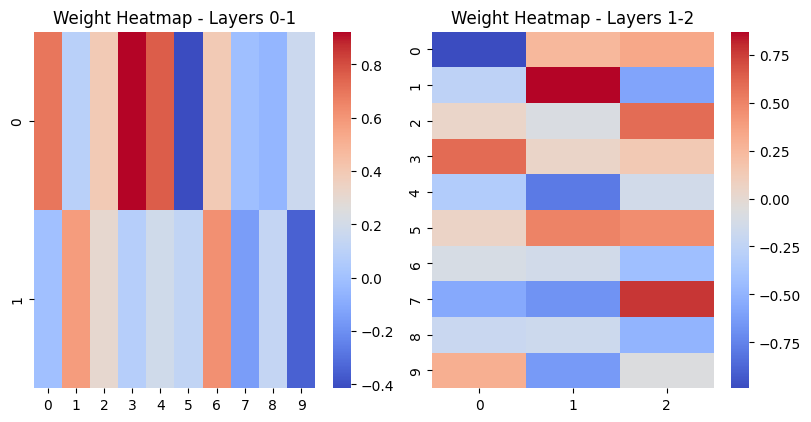

Epoch 17/25, Test Accuracy: 62.67% Loss: 332.1173329682004, Correct: 188, All: 300 
Layers 0-1: Mean=0.2237398638400081, Std=0.35176690550814205
Layers 1-2: Mean=-0.05698779581235746, Std=0.46822429335824634


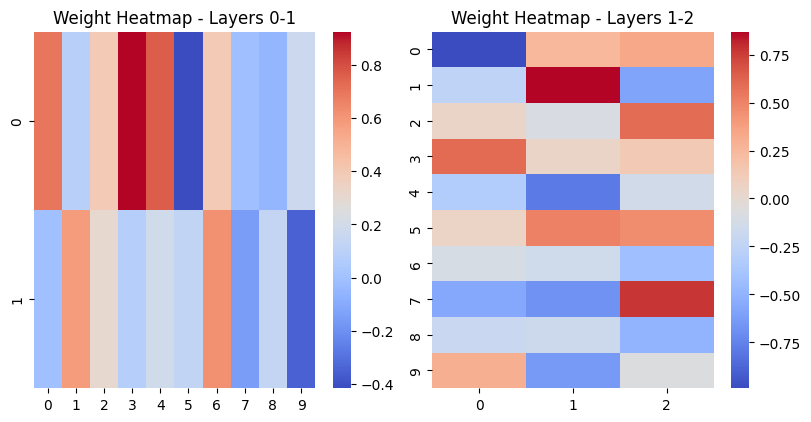

Epoch 18/25, Test Accuracy: 63.33% Loss: 332.22889050111587, Correct: 190, All: 300 
Layers 0-1: Mean=0.2232974240128336, Std=0.3521236078487223
Layers 1-2: Mean=-0.05698779581235747, Std=0.46831207148491033


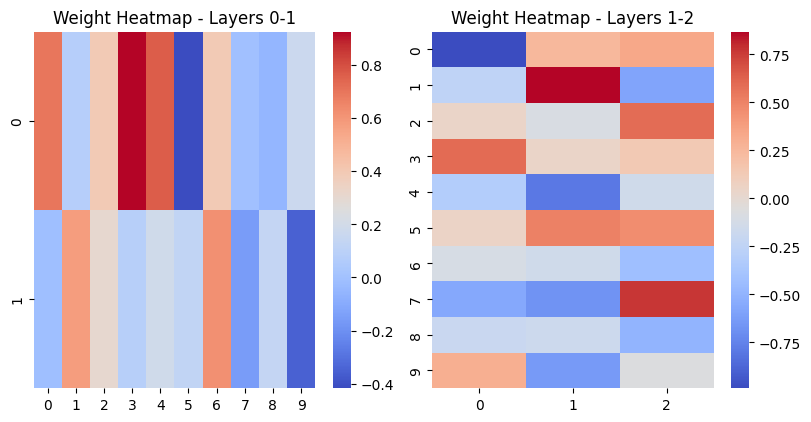

Epoch 19/25, Test Accuracy: 63.67% Loss: 332.34500194321424, Correct: 191, All: 300 
Layers 0-1: Mean=0.22285777715420046, Std=0.3524900359651062


KeyboardInterrupt: 

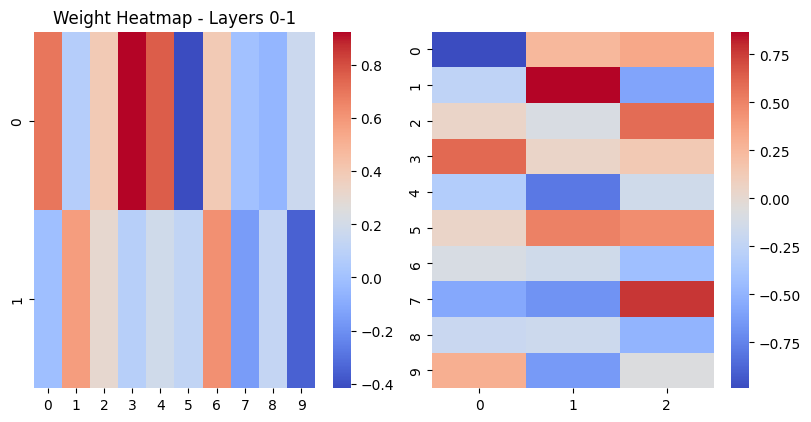

In [80]:
import numpy as np
import pandas as pd

test = pd.read_csv("classification/data.three_gauss.test.100.csv", sep=",")
train = pd.read_csv("classification/data.three_gauss.train.100.csv", sep=",")

train_vectors = np.array(train[["x", "y"]])
train_results = np.array(train["cls"] - 1)
test_vectors = np.array(test[["x", "y"]])
test_results = np.array(test["cls"] - 1)

num_classes = 3
train_results = np.eye(num_classes)[train_results]
test_results = np.eye(num_classes)[test_results]

nn = NeuralNetwork(input_size = 2, output_size = num_classes, hidden_size = 10, hidden_layers_count = 1, num_epochs = 25, learning_rate=0.0001, inner_activation_function = ActivationFuction.RELU, visualize=True)
nn.train_and_check_acc(train_vectors, train_results, test_vectors, test_results)

In [226]:
import numpy as np
import pandas as pd

test = pd.read_csv("regression/data.cube.test.100.csv", sep=",")
train = pd.read_csv("regression/data.cube.train.100.csv", sep=",")

train_vectors = np.array(train["x"])
train_results = np.array(train["y"])
test_vectors = np.array(test["x"])
test_results = np.array(test["y"])

nn = NeuralNetwork(hidden_size = 6, hidden_layers_count = 1, num_epochs = 20, inner_activation_function = ActivationFuction.RELU, problem = Problem.Regression)
nn.train_and_check_acc(train_vectors, train_results, test_vectors, test_results)

Epoch 1/20, Test Accuracy: 134243.47854882723
Epoch 2/20, Test Accuracy: 133524.77838048464
Epoch 3/20, Test Accuracy: 133266.78702831615
Epoch 4/20, Test Accuracy: 133173.03395099868
Epoch 5/20, Test Accuracy: 133138.80841236367
Epoch 6/20, Test Accuracy: 133126.2929665212
Epoch 7/20, Test Accuracy: 133121.71354422753
Epoch 8/20, Test Accuracy: 133120.03754670746
Epoch 9/20, Test Accuracy: 133119.42410677206
Epoch 10/20, Test Accuracy: 133119.19957185013
Epoch 11/20, Test Accuracy: 133119.11738533387
Epoch 12/20, Test Accuracy: 133119.08730248164
Epoch 13/20, Test Accuracy: 133119.07629119421
Epoch 14/20, Test Accuracy: 133119.0722607082
Epoch 15/20, Test Accuracy: 133119.07078542002
Epoch 16/20, Test Accuracy: 133119.07024541692
Epoch 17/20, Test Accuracy: 133119.0700477583
Epoch 18/20, Test Accuracy: 133119.06997540893
Epoch 19/20, Test Accuracy: 133119.0699489267
Epoch 20/20, Test Accuracy: 133119.0699392333
